# U-Net 
Mejoras: ReflectionPad3d (en vez de zero padding), posibilidad de agregar dropout, posibilidad de optar por upsamplig o convtranspose


In [1]:
import os 
import time
import math
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, jaccard_score

In [2]:
"""
______________________________________encoding block_______________________________
"""
class encoding_block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=0, stride=1, dilation=1, dropout=True):
        super().__init__()
            
        layers = [nn.ReflectionPad3d(padding=(kernel_size -1)//2),
                  nn.Conv3d(in_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  nn.ReflectionPad3d(padding=(kernel_size - 1)//2),
                  nn.Conv3d(out_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.PReLU(),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  ]

        if dropout:
            layers.append(nn.Dropout())

        self.encoding_block = nn.Sequential(*layers)

    def forward(self, input):

        output = self.encoding_block(input)

        return output
"""
______________________________________decoding block_______________________________
"""
class decoding_block(nn.Module):
    def __init__(self, in_size, out_size, upsampling=True):
        super().__init__()

        if upsampling:
            self.up = nn.Sequential(nn.Upsample(mode='nearest', scale_factor=2),
                                    nn.Conv3d(in_size, out_size, kernel_size=1))

        else:
            self.up = nn.ConvTranspose3d(in_size, out_size, kernel_size=2, stride=2)

        self.conv = encoding_block(in_size, out_size)

    def forward(self, input):

        output = self.up(input)

        return output

"""
______________________________________Main UNet architecture_______________________________
"""
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512], dropout=False,  upsampling=True):
        super().__init__()
        
        self.ups = nn.ModuleList() #no se puede usar una lista tipo [] porque se nececita almacenar capas convolucionales
        self.downs = nn.ModuleList() 
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
#Encoder
        for feature in features:
            self.downs.append(encoding_block(in_channels, feature, dropout = dropout))
            in_channels = feature
#Base        
        self.bottleneck = encoding_block(features[-1], features[-1]*2) #512 a 1024
            
#Decoder
        for feature in reversed(features):#los tamaños ahora van del ultimo al primero
            self.ups.append(decoding_block(feature*2, feature))
            self.ups.append(encoding_block(feature*2, feature))
            
#Final
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
                   

    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]# da vuelta la lista para usarla en la subida
        
        for idx in range(0, len(self.ups), 2):#se hace un paso de 2 porque un solo paso va a equivaler al up and doubleconv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

## * Comprobar funcionamiento 
Se le ingresa a la arquitectura un tensor random con las dimensiones de los volúmenes de entrada y se verifica que la salida sea con las dimensiones de las dosis

In [3]:
model = UNet()
x = torch.randn((1, 4, 64, 64, 64))
output = model(x)
output.shape

torch.Size([1, 1, 64, 64, 64])

# Métricas

## IoU

In [4]:
def dice(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)
    return   torch.mean((2 * intersect) /(union+smooth))

## Dice

In [5]:
def iou(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

## F1 y Jaccard

In [6]:
def pre (y):
    y = y.cpu().numpy()
    y = y.astype(np.uint8)
    y = y.reshape(-1)
    return y

def f1 (true, pred):
    y_true = pre(true)
    y_pred = pre(pred)
    return f1_score(y_true, y_pred, average='macro')

def jac (true, pred):
    y_true = pre(true)
    y_pred = pre(pred)
    return jaccard_score(y_pred,  y_true, average='macro') 

# BCEDiceLoss

In [7]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss()(true, pred).double()
        # Dice Loss
        dice_coef = ((-(true-pred)**2+1).double().sum()) / (math.prod(true.shape))
        return bce_loss + (1 - dice_coef)

# Utils

## Seed

In [8]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

## Calculo del tiempo

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

## Data loader

In [10]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [11]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volumenes no es equivalente a la cantidad de mascaras"
        return len(self.x)
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix])
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64)
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2)
        mask_e = mask/36.25
        mask_tensor = torch.tensor(mask_e).unsqueeze(0)
        
        return img_tensor, mask_tensor

In [12]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis ):
    direc = Path(carpeta +"/")
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)]
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)]
    estruc = sorted(estruc)
    dosis = sorted(dosis)
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volumenes no es equivalente a la cantidad de mascaras")
    print('La carpeta {} tiene {} volumenes y la carpeta {} tiene {} mascaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

# * Entrenamiento de un solo volumen

In [13]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')
dataset = Dataset(estruc[:1], dosis[:1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
x, y = next(iter(dataloader))

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [14]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [15]:
def fit(model, X, y, epochs=1, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.to(device)
    X = X.to(device=device, dtype=torch.float)
    y = y.to(device=device, dtype=torch.float)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        dices = dice(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.3f} dice {dices:.3f}")

In [16]:
fit(model, x, y, epochs=5000)

Epoch 1/5000 loss 0.89302 iou 0.037 dice 0.071
Epoch 2/5000 loss 0.79971 iou 0.016 dice 0.031
Epoch 3/5000 loss 0.63032 iou 0.020 dice 0.039
Epoch 4/5000 loss 0.57229 iou 0.026 dice 0.050
Epoch 5/5000 loss 0.53883 iou 0.027 dice 0.053
Epoch 6/5000 loss 0.49921 iou 0.028 dice 0.054
Epoch 7/5000 loss 0.46585 iou 0.028 dice 0.054
Epoch 8/5000 loss 0.44436 iou 0.028 dice 0.054
Epoch 9/5000 loss 0.42194 iou 0.028 dice 0.054
Epoch 10/5000 loss 0.40528 iou 0.029 dice 0.056
Epoch 11/5000 loss 0.38687 iou 0.030 dice 0.058
Epoch 12/5000 loss 0.37244 iou 0.031 dice 0.060
Epoch 13/5000 loss 0.35796 iou 0.033 dice 0.064
Epoch 14/5000 loss 0.34979 iou 0.036 dice 0.070
Epoch 15/5000 loss 0.33288 iou 0.039 dice 0.074
Epoch 16/5000 loss 0.32190 iou 0.038 dice 0.073
Epoch 17/5000 loss 0.31135 iou 0.037 dice 0.072
Epoch 18/5000 loss 0.30324 iou 0.040 dice 0.076
Epoch 19/5000 loss 0.29301 iou 0.044 dice 0.084
Epoch 20/5000 loss 0.28505 iou 0.048 dice 0.091
Epoch 21/5000 loss 0.27692 iou 0.048 dice 0.091
E

In [17]:
model.eval()
with torch.no_grad():
    output = model(x.to(device=device, dtype=torch.float))[0]

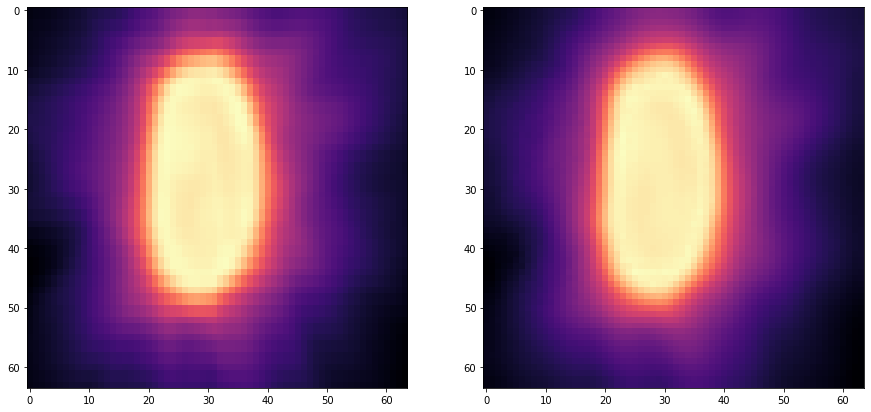

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(y[0,0,:,:,24],cmap="magma")
ax2.imshow(output[0,:,:,24].squeeze().cpu().numpy(),cmap="magma")
plt.show()

# Resumen de arquitectura

In [19]:
summary(model, (4, 64, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad3d-1        [-1, 4, 66, 66, 66]               0
            Conv3d-2       [-1, 64, 64, 64, 64]           6,976
       BatchNorm3d-3       [-1, 64, 64, 64, 64]             128
             PReLU-4       [-1, 64, 64, 64, 64]               1
   ReflectionPad3d-5       [-1, 64, 66, 66, 66]               0
            Conv3d-6       [-1, 64, 64, 64, 64]         110,656
             PReLU-7       [-1, 64, 64, 64, 64]               1
       BatchNorm3d-8       [-1, 64, 64, 64, 64]             128
             PReLU-9       [-1, 64, 64, 64, 64]               1
   encoding_block-10       [-1, 64, 64, 64, 64]               0
        MaxPool3d-11       [-1, 64, 32, 32, 32]               0
  ReflectionPad3d-12       [-1, 64, 34, 34, 34]               0
           Conv3d-13      [-1, 128, 32, 32, 32]         221,312
      BatchNorm3d-14      [-1, 128, 32,

# Entrenamiento

In [20]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [21]:
dataset = {
    "train" : Dataset(estruc[:180], dosis[:180]),
    "test" : Dataset(estruc[180:], dosis[180:])}

print(f'La cantidad de imágenes de entrenamiento son {len(dataset["train"])} y la cantidad de validación son {len(dataset["test"])}.')

La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.


In [22]:
dataloader = {
    "train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
    "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True) }

imges, maskes = next(iter(dataloader["train"]))
imges.shape, maskes.shape

(torch.Size([2, 4, 64, 64, 64]), torch.Size([2, 1, 64, 64, 64]))

In [23]:
def train(model, dataloader, hist, met, optimizer, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['train'])
    train_loss= []
    model.train()
    for imges, maskes in bar:
        imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(imges)
        loss = loss_fn(y_pred, maskes)
        loss.backward() 
        optimizer.step() 
        ious = iou(y_pred, maskes)
        dices = dice(y_pred, maskes)
        train_loss.append(loss.item())
        epoch_loss += loss.item()
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
    hist['loss'].append(np.mean(train_loss))
    met["IoU"].append(np.mean(ious.cpu().numpy()*1))
    met["Dice"].append(np.mean(dices.cpu().numpy()*1))
    epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [24]:
def evaluate(model, dataloader, hist, met, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['test'])
    test_loss = []
    model.eval()
    with torch.no_grad():
        for imges, maskes in bar:
            imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
            y_pred = model(imges)
            loss = loss_fn(y_pred, maskes)
            epoch_loss += loss.item()
            test_loss.append(loss.item())
            ious = iou(y_pred, maskes)
            dices = dice(y_pred, maskes)
            bar.set_description(f"test_loss {np.mean(test_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
        hist['test_loss'].append(np.mean(test_loss))
        met["IoU_test"].append(np.mean(ious.cpu().numpy()*1))
        met["Dice_test"].append(np.mean(dices.cpu().numpy()*1))
        epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [25]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [26]:
def fit(epochs=10, loss_fn = torch.nn.MSELoss(), model=model, device=device):
    if __name__ == "__main__":

        seeding(42)
        create_dir("file")

        epochs = epochs
        lr = 1e-4
        checkpoint_path = "file/checkpoint.pth" # Para guardar el modelo 

        dataloaders = dataloader

        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
        loss_fn = loss_fn
        
        # Entrenamiento
        hist = {'loss': [], 'test_loss': []}
        met = {"IoU": [], "Dice": [], "IoU_test": [], "Dice_test": []}
        best_valid_loss = float("inf")
        start_time = time.time()

        for epoch in range(1, epochs+1):
            print(f"\nEpoch {epoch}/{epochs}")

            train_loss, hist, met = train(model, dataloaders, hist, met, optimizer, loss_fn, device)
            valid_loss, hist, met = evaluate(model, dataloaders, hist, met, loss_fn, device)
        # Guardar el modelo entrenado 
            if valid_loss < best_valid_loss:
                data_str = f"Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving checkpoint: {checkpoint_path}"
                print(data_str)

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), checkpoint_path)
        # Mostrar avance del entrenamiento    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        data_str = f' Entrenamiento de {epochs} epocas finalizado en {epoch_mins}m {epoch_secs}s\n'
        print()
        print(data_str)
        
        return hist, met

## 10 épocas con MSELoss

In [27]:
hist, met = fit(epochs=10, loss_fn = torch.nn.MSELoss())


Epoch 1/10


test_loss 0.02483 iou 0.208 dice 0.344: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.41it/s]


Valid loss improved from inf to 0.0248. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.01674 iou 0.209 dice 0.346: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.70it/s]


Valid loss improved from 0.0248 to 0.0167. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.01087 iou 0.327 dice 0.493: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]


Valid loss improved from 0.0167 to 0.0109. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.00818 iou 0.428 dice 0.599: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.88it/s]


Valid loss improved from 0.0109 to 0.0082. Saving checkpoint: file/checkpoint.pth

Epoch 5/10


test_loss 0.00733 iou 0.392 dice 0.564: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]


Valid loss improved from 0.0082 to 0.0073. Saving checkpoint: file/checkpoint.pth

Epoch 6/10


test_loss 0.00875 iou 0.388 dice 0.559: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.35it/s]



Epoch 7/10


test_loss 0.00592 iou 0.447 dice 0.617: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.57it/s]


Valid loss improved from 0.0073 to 0.0059. Saving checkpoint: file/checkpoint.pth

Epoch 8/10


test_loss 0.00671 iou 0.389 dice 0.560: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.83it/s]



Epoch 9/10


test_loss 0.00645 iou 0.319 dice 0.483: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.35it/s]



Epoch 10/10


test_loss 0.00531 iou 0.375 dice 0.545: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.93it/s]


Valid loss improved from 0.0059 to 0.0053. Saving checkpoint: file/checkpoint.pth

 Entrenamiento de 10 epocas finalizado en 11m 3s



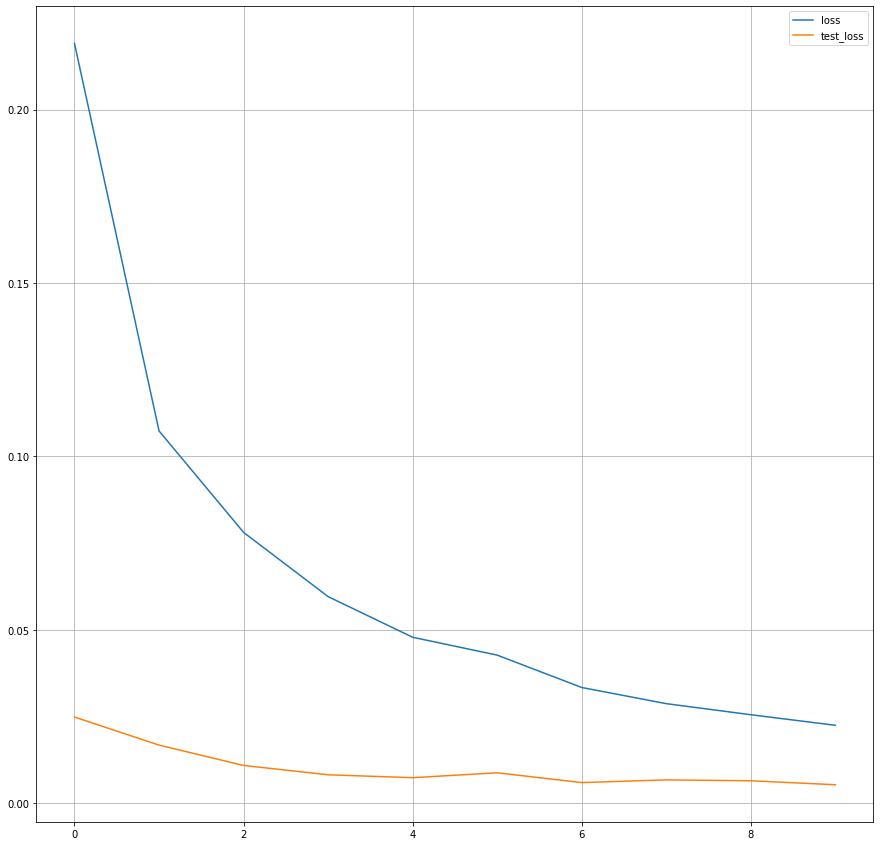

In [28]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

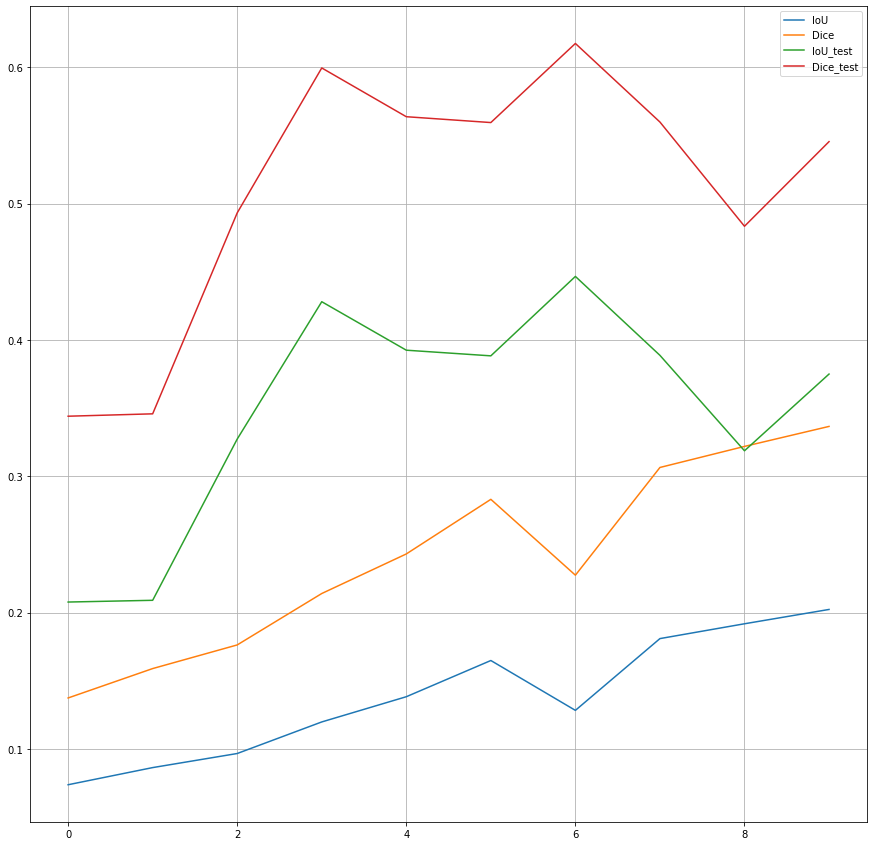

In [29]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(15,15))
plt.show()

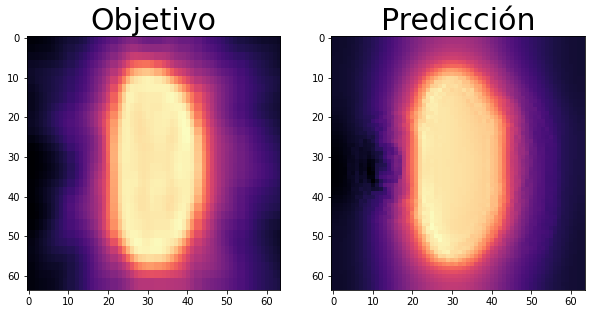

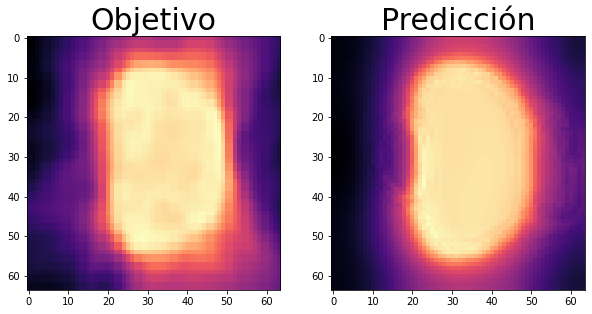

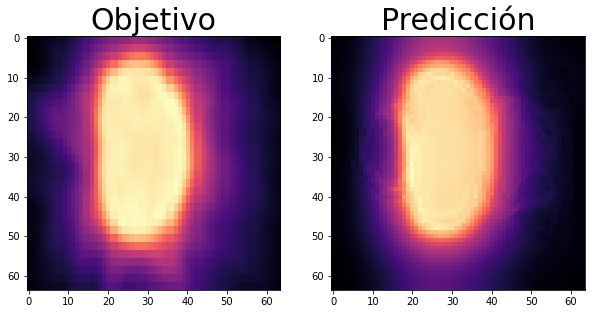

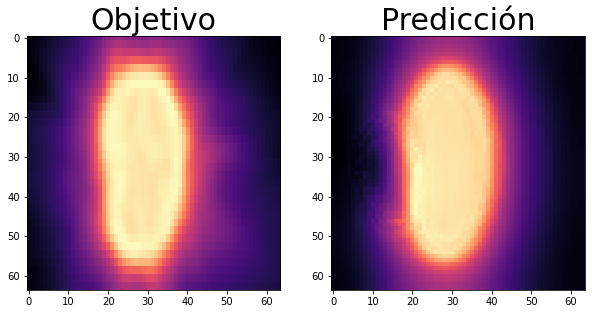

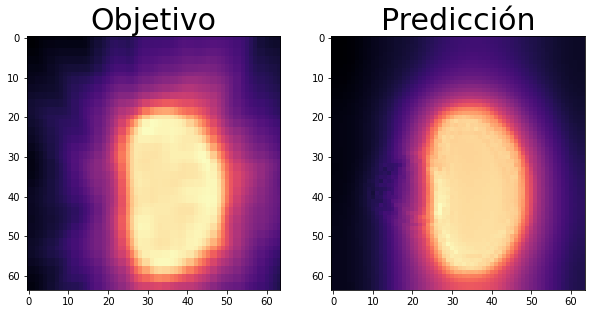

In [30]:
#10 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()